# Parallelized Leaky Neuron as a Smooth Membrane Potential Filter

This notebook demonstrates a simple setup for using a parallelized leaky neuron (implemented via a 1D convolutional kernel) as a *smooth membrane potential filter*.  
We show how the filter transforms different 1D temporal signals — an impulse and a noisy signal — and how stacking two filters produces a smoother, higher-order temporal response.  

This structure mimics the temporal smoothing or synaptic delay behavior that can be useful in closed-loop EEG-based control systems


### Setup and Layer Creation

In this section, we initialize the **parallelized leaky neuron** layer that serves as our filter.  
The neuron behaves like a first-order low-pass system: each timestep’s membrane potential depends on a decayed version of its past value plus the new input.  

We instantiate two identical layers (`layer1`, `layer2`) so that later we can examine both a **single-filter** and a **double-filter** cascade.  
The second stage effectively produces a smoother, higher-order membrane response.


In [16]:
# --- Setup and layer creation ---
import torch
from snntorch._neurons.stateleaky import StateLeaky

# Configuration
TIMESTEPS = 2000
BATCH = 1          # single sample for visualization
CHANNELS = 1       # one channel for simplicity
BETA = 0.9         # decay constant (controls smoothing)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Create the parallelized leaky neuron layers
# IMPORTANT: set output=False to return the membrane potential (not spikes)
layer1 = StateLeaky(beta=BETA, channels=CHANNELS, output=False).to(device)
layer2 = StateLeaky(beta=BETA, channels=CHANNELS, output=False).to(device)

print(f"Using device: {device}")
print(layer1)

Using device: cuda
StateLeaky()


### Generating Example Inputs

To visualize the filter behavior, we’ll drive the neuron with two types of test signals:

1. **Impulse input** — a single spike at *t = 0*; this reveals the neuron’s **impulse response** (its inherent smoothing kernel).  
2. **Noisy input** — a random signal resembling EEG noise; this shows how the filter attenuates high-frequency fluctuations.  

Both signals are shaped `(TIMESTEPS, BATCH, CHANNELS)` to match the layer’s expectations, and will later be passed through one and then two stacked filters.


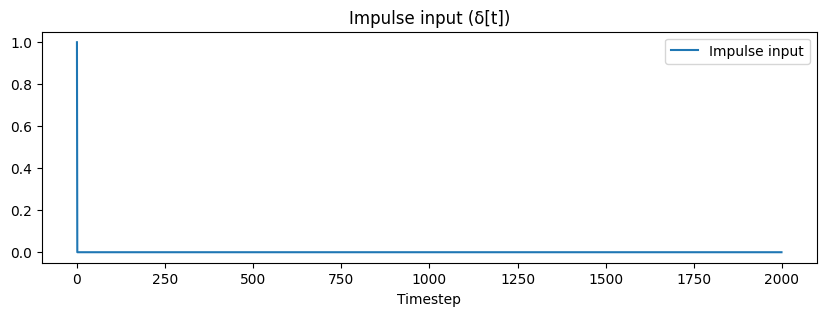

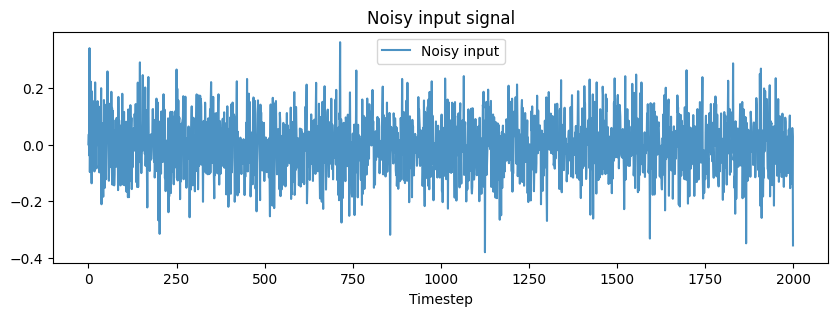

In [17]:
import matplotlib.pyplot as plt

# Time axis
t = torch.arange(TIMESTEPS, device=device).float()

# (1) Impulse: all zeros except one spike at t = 0
impulse = torch.zeros(TIMESTEPS, BATCH, CHANNELS, device=device)
impulse[0, 0, 0] = 1.0

# (2) Noisy input: random Gaussian noise (can represent EEG-like fluctuations)
noisy = torch.randn(TIMESTEPS, BATCH, CHANNELS, device=device) * 0.1

# Quick visualization of both signals (on CPU for matplotlib)
plt.figure(figsize=(10, 3))
plt.plot(impulse[:, 0, 0].cpu(), label="Impulse input")
plt.title("Impulse input (δ[t])")
plt.xlabel("Timestep")
plt.legend()
plt.show()

plt.figure(figsize=(10, 3))
plt.plot(noisy[:, 0, 0].cpu(), label="Noisy input", alpha=0.8)
plt.title("Noisy input signal")
plt.xlabel("Timestep")
plt.legend()
plt.show()

### Single Filter Response (Impulse Input)

We’ll begin by passing the **impulse signal** through a single `StateLeaky` layer.  
Because this neuron operates as a leaky integrator (without reset), its output should follow an **exponential decay**, similar to a first-order low-pass filter’s impulse response.

Plotting the input and output over time reveals the inherent smoothing behavior of the filter — this corresponds to the membrane potential’s natural relaxation after an instantaneous input.


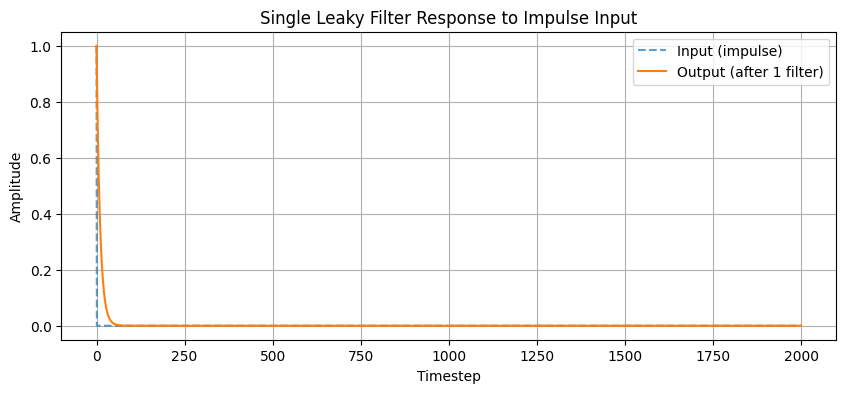

In [18]:
# --- Single filter response (impulse input) ---

with torch.no_grad():
    out_tuple = layer1.forward(impulse)
    # If StateLeaky returns (output, state), unpack the first element
    if isinstance(out_tuple, tuple):
        output_single = out_tuple[0]
    else:
        output_single = out_tuple

# Plot input vs. output
plt.figure(figsize=(10, 4))
plt.plot(impulse[:, 0, 0].cpu(), label="Input (impulse)", linestyle="--", alpha=0.7)
plt.plot(output_single[:, 0, 0].cpu(), label="Output (after 1 filter)")
plt.title("Single Leaky Filter Response to Impulse Input")
plt.xlabel("Timestep")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()


### Double Filter Response (Impulse Input)

Next, we cascade two identical leaky filters — `layer1` followed by `layer2`.  
This setup acts as a **second-order low-pass filter**, producing an even smoother and slower-decaying membrane response.

Conceptually:
- The first layer integrates the input spike into a decaying potential.
- The second layer integrates that already-smoothed signal again, yielding a “doubly smoothed” curve.

This demonstrates how stacking parallelized leaky filters naturally models **synaptic delay** or **multi-timescale membrane dynamics**.


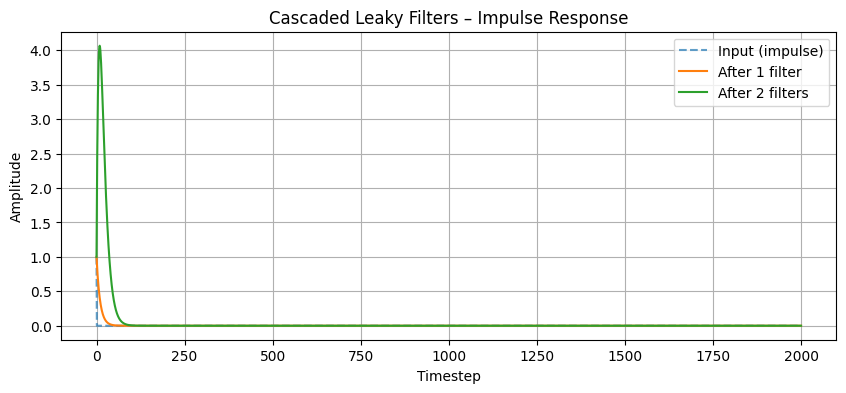

In [19]:
# --- Double filter response (impulse input) ---

with torch.no_grad():
    # First filter
    out1 = layer1(impulse)
    # Second filter processes the output of the first
    out2 = layer2(out1)

# Plot the progression
plt.figure(figsize=(10, 4))
plt.plot(impulse[:, 0, 0].cpu(), "--", alpha=0.7, label="Input (impulse)")
plt.plot(out1[:, 0, 0].cpu(), label="After 1 filter")
plt.plot(out2[:, 0, 0].cpu(), label="After 2 filters")
plt.title("Cascaded Leaky Filters – Impulse Response")
plt.xlabel("Timestep")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()


### Filtering a Noisy Input Signal

To illustrate the smoothing behavior more intuitively, we’ll pass a **noisy signal** through one and then two filters.  
This demonstrates how cascading leaky filters can suppress high-frequency noise — similar to how biological synapses and membranes smooth fluctuating neural inputs.

- The **raw signal** is random Gaussian noise (representing EEG-like input).  
- The **one-filter output** shows mild smoothing.  
- The **two-filter output** appears more stable and delayed — capturing the effect of a slower, smoother membrane potential.


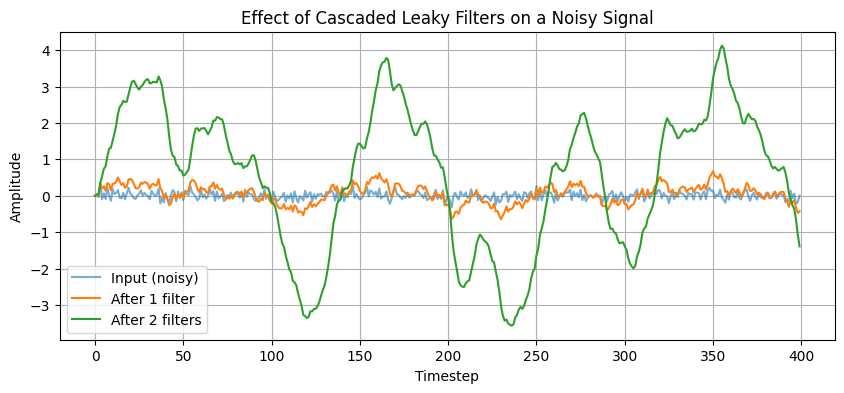

In [20]:
# --- Filtering a noisy signal ---

with torch.no_grad():
    out1_noisy = layer1(noisy)
    out2_noisy = layer2(out1_noisy)

# Plot a short segment for clarity
segment = slice(0, 400)

plt.figure(figsize=(10, 4))
plt.plot(noisy[segment, 0, 0].cpu(), label="Input (noisy)", alpha=0.6)
plt.plot(out1_noisy[segment, 0, 0].cpu(), label="After 1 filter")
plt.plot(out2_noisy[segment, 0, 0].cpu(), label="After 2 filters")
plt.title("Effect of Cascaded Leaky Filters on a Noisy Signal")
plt.xlabel("Timestep")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()


### Discussion and Interpretation

In this notebook, we demonstrated how a reset-less **leaky neuron** implemented via a **causal 1D convolution** behaves as a simple **state-space-style low-pass filter**.  
Key takeaways:

- **Single filter:** acts as a *first-order leaky integrator*, producing an exponential decay when driven by an impulse.  
  This mirrors the basic membrane charging and discharging behavior of biological neurons.

- **Two filters in cascade:** form a *second-order smooth filter*.  
  The second stage integrates the already-smoothed signal, delaying and further smoothing the response.  
  This is analogous to **synaptic delay** or layered membrane filtering in biophysical systems.

- **Noisy input case:** cascading filters progressively suppresses high-frequency fluctuations, resulting in a stable, slowly varying output suitable for EEG-based control tasks.

Overall, the parallelized `StateLeaky` formulation allows full-sequence computation using convolution instead of recurrent iteration—efficiently mapping the leaky-integrator dynamics into the same computational style as **state-space models (SSMs)**.  
This structure can therefore serve as a lightweight temporal filter for continuous-time neural signals, offering both biological plausibility and GPU-friendly parallelization.
